In [1]:
import numpy
from matplotlib import pyplot, animation
from IPython.display import HTML
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
# Set parameters.
L = 1.0  # length of the rod
nx = 51  # number of locations on the rod
dx = L / (nx - 1)  # distance between two consecutive locations
alpha = 1.22e-3  #  thermal diffusivity of the rod
q = 0.0  # temperature gradient on the right side of the rod

# Define the locations along the rod.
x = numpy.linspace(0.0, L, num=nx)

# Set the initial temperature along the rod.
T0 = numpy.zeros(nx)
T0[0] = 100.0
print(dx)

0.02


In [4]:
print(T0, len(T0))

[100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.] 51


In [5]:
from scipy import linalg

In [6]:
def lhs_operator(N, sigma):
    """
    Computes and returns the implicit operator
    of the system for the 1D diffusion equation.
    We use backward Euler method, Dirichlet condition
    on the left side of the domain and zero-gradient
    Neumann condition on the right side.
    
    Parameters
    ----------
    N : integer
        Number of interior points.
    sigma : float
        Value of alpha * dt / dx**2.
    
    Returns
    -------
    A : numpy.ndarray
        The implicit operator as a 2D array of floats
        of size N by N.
    """
    # Setup the diagonal of the operator.
    D = numpy.diag((2.0 + 1.0 / sigma) * numpy.ones(N))
    # Setup the Neumann condition for the last element.
    D[-1, -1] = 1.0 + 1.0 / sigma
    # Setup the upper diagonal of the operator.
    U = numpy.diag(-1.0 * numpy.ones(N - 1), k=1)
    # Setup the lower diagonal of the operator.
    L = numpy.diag(-1.0 * numpy.ones(N - 1), k=-1)
    # Assemble the operator.
    A = D + U + L
    return A

In [7]:
A_trial = lhs_operator(len(T0) - 2, 2.0)
print(A_trial, numpy.shape(A_trial))

[[ 2.5 -1.   0.  ...  0.   0.   0. ]
 [-1.   2.5 -1.  ...  0.   0.   0. ]
 [ 0.  -1.   2.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  2.5 -1.   0. ]
 [ 0.   0.   0.  ... -1.   2.5 -1. ]
 [ 0.   0.   0.  ...  0.  -1.   1.5]] (49, 49)


In [8]:
def rhs_vector(T, sigma, qdx):
    """
    Computes and returns the right-hand side of the system
    for the 1D diffusion equation, using a Dirichlet condition
    on the left side and a Neumann condition on the right side.
    
    Parameters
    ----------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    sigma : float
        Value of alpha * dt / dx**2.
    qdx : float
        Value of the temperature flux at the right side.
    
    Returns
    -------
    b : numpy.ndarray
        The right-hand side of the system as a 1D array of floats.
    """
    b = T[1:-1] / sigma
    # Set Dirichlet condition.
    b[0] += T[0]
    # Set Neumann condition.
    b[-1] += qdx
    return b

In [10]:
def btcs_implicit(T0, nt, dt, dx, alpha, q):
    """
    Computes and returns the temperature along the rod
    after a given number of time steps.
    
    The function uses Euler implicit in time,
    central differencing in space, a Dirichlet condition
    on the left side, and a Neumann condition on the
    right side.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 1D array of floats.
    nt : integer
        Number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Distance between two consecutive locations.
    alpha : float
        Thermal diffusivity of the rod.
    q : float
        Value of the temperature gradient on the right side.
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 1D array of floats.
    """
    sigma = alpha * dt / dx**2
    # Create the implicit operator of the system.
    A = lhs_operator(len(T0) - 2, sigma)
    # Integrate in time.
    T = T0.copy()
    store = [T0.copy()]
    for n in range(nt):
        # Generate the right-hand side of the system.
        b = rhs_vector(T, sigma, q * dx)
        # Solve the system with scipy.linalg.solve.
        T[1:-1] = linalg.solve(A, b)
        # Apply the Neumann boundary condition.
        T[-1] = T[-2] + q * dx
        store.append(T.copy())
    return store

In [11]:
# Set the time-step size based on CFL limit.
sigma = 5.0
dt = sigma * dx**2 / alpha  # time-step size
print(dt)
nt = 1000  # number of time steps to compute

# Compute the temperature along the rod.
T_store = btcs_implicit(T0, nt, dt, dx, alpha, q)
#print(T_store, len(T_store))

1.639344262295082


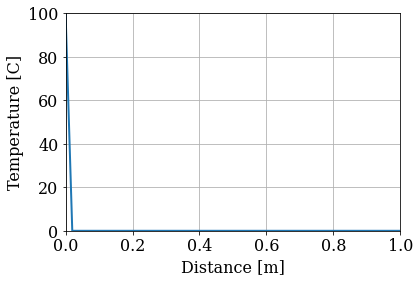

In [12]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel('Distance [m]')
pyplot.ylabel('Temperature [C]')
pyplot.grid()
line, = pyplot.plot(x, T0, color='C0', linestyle='-', linewidth=2)
pyplot.xlim(0.0, L)
pyplot.ylim(0.0, 100.0);

In [13]:
def update_plot(n, T_store):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(T_store[n])
    #line_1.set_ydata(rho_hist_1[n])

In [14]:
# Create an animation of the traffic density.
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(T_store,),
                               interval=50)
# Display the video.
HTML(anim.to_html5_video())